
#**Tema projekta: Analiza tezine saobracajnih nezgoda**

**Ucitavanje potrebnih biblioteka za rad**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

**Ucitavanje i prikaz ulaznih podataka**

Ulazni podaci predstavljaju informacije o saobracajnim nezgodama koje su se dogadjale u periodu 2016-2020. godine u SAD. Sastoji se od 49 kolona koje predstavljaju obelezja i oko 3.5 miliona vrsta koje predstavljaju merenja. Obelezja koja su koriscena u ovom datasetu su tezina saobracajne nesrece, pocetak nesrece, kraj nesrece, distanca, opis nesrece, ulica, drzava, grad, temperatura, uticaj vetra, pritisak, smer vetra, brzina vetra, vremenski uslovi, uticaj guzve, doba dana, zalaska i izlaska Sunca, astronomskih i nautickih uticaja itd.

In [ ]:
drive.mount('/content/drive')
podaci=pd.read_csv('/content/drive/My Drive/US_Accidents_June20.csv')
podaci.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,I-75 S,R,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


**Prikaz strukture obelezja**

U nastavku mozemo videti spisak svih obelezja, kao i tip podataka koje svako obelezje predstavlja. Podaci su mesoviti, imamo podatke tipa object, float, integer i boolean.

In [ ]:
podaci.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3513740 entries, 0 to 3513739
Data columns (total 49 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   TMC                    float64
 3   Severity               int64  
 4   Start_Time             object 
 5   End_Time               object 
 6   Start_Lat              float64
 7   Start_Lng              float64
 8   End_Lat                float64
 9   End_Lng                float64
 10  Distance(mi)           float64
 11  Description            object 
 12  Number                 float64
 13  Street                 object 
 14  Side                   object 
 15  City                   object 
 16  County                 object 
 17  State                  object 
 18  Zipcode                object 
 19  Country                object 
 20  Timezone               object 
 21  Airport_Code           object 
 22  Weather_Timestamp 

#Ciscenje podataka i odabir obelezja

Najpre, pre nego sto pristupimo izradi algoritama, potrebno je pripremiti podatke, odosno izvrsiti pretprocesiranje podataka. Najpre cemo izbrojati koliko svako od obelezja ima null vrednosti, posto nam te vrednosti nisu od interesa, izbacicemo ih u daljoj obradi.

In [ ]:
podaci.isna().sum()

ID                             0
Source                         0
TMC                      1034922
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  2478818
End_Lng                  2478818
Distance(mi)                   0
Description                    1
Number                   2262954
Street                         0
Side                           0
City                         112
County                         0
State                          0
Zipcode                     1069
Country                        0
Timezone                    3880
Airport_Code                6758
Weather_Timestamp          43325
Temperature(F)             65736
Wind_Chill(F)            1868256
Humidity(%)                69691
Pressure(in)               55884
Visibility(mi)             75861
Wind_Direction             58877
Wind_Speed(mph)           454613
Precipitat

Izbacujemo ona obelezja koja imaju najvise null vrednosti i vrsimo prikaz preostalih obelezja jer je njihova informativnost jako mala, veliki je procenat vrednosti koje ne mozemo iskoristiti, pa u cilju smanjenja kolicine podataka, redukcije dimenzija, neka obelezja se izbacuju.

In [ ]:
podaci.drop(['TMC','End_Lat','End_Lng','Number','Wind_Chill(F)','Weather_Timestamp','Precipitation(in)','Wind_Speed(mph)','Pressure(in)','Wind_Direction','Description','Zipcode','Country','Timezone','Airport_Code','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight'],axis=1,inplace=True)
podaci.drop(['Source'],axis=1,inplace=True)
podaci.isna().sum()

ID                       0
Severity                 0
Start_Time               0
End_Time                 0
Start_Lat                0
Start_Lng                0
Distance(mi)             0
Street                   0
Side                     0
City                   112
County                   0
State                    0
Temperature(F)       65736
Humidity(%)          69691
Visibility(mi)       75861
Weather_Condition    76143
Amenity                  0
Bump                     0
Crossing                 0
Give_Way                 0
Junction                 0
No_Exit                  0
Railway                  0
Roundabout               0
Station                  0
Stop                     0
Traffic_Calming          0
Traffic_Signal           0
Turning_Loop             0
Sunrise_Sunset         116
dtype: int64

Od preostalih obelezja, posto je procenat null vrednosti dosta manji nego kod vec odstranjenih obelezja, ostatak obelezja moze koristiti u predikciji tako sto ce samo one null vrednosti biti izbrisane, a ostatak podataka ce biti na raspolaganju jer nam ostaje dosta veliki broj podataka kojim mozemo baratati, vise od 3 miliona merenja za svako obelezje. To se moze obaviti uz pomoc funkcije **dropna()** gde mozemo videti da nam je preostalo 38 obelezja i 3414370 merenja.

In [ ]:
podaci.dropna(axis=0, how='any',inplace=True)
podaci.shape

(3414371, 30)

Posto je na raspolaganju pocetno vreme i krajnje vreme nesrece, moze se napraviti vestacko obelezje koje govori o trajanju saobracajne nesrece tako sto ce se oduzeti krajnje i pocetno vreme za svako merenje sto se moze videti daljem kodu.

In [ ]:
podaci['Duration'] = (pd.to_datetime(podaci['End_Time'])-pd.to_datetime(podaci['Start_Time'])).astype('timedelta64[m]')
podaci.drop(['Start_Time','End_Time'],axis=1,inplace=True)
podaci.head()

,ID,Severity,Start_Lat,Start_Lng,Distance(mi),Street,Side,City,County,State,Temperature(F),Humidity(%),Visibility(mi),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Duration
0,A-1,3,39.865147,-84.058723,0.01,I-70 E,R,Dayton,Montgomery,OH,36.9,91.0,10.0,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,314.0
1,A-2,2,39.928059,-82.831184,0.01,Brice Rd,L,Reynoldsburg,Franklin,OH,37.9,100.0,10.0,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,30.0
2,A-3,2,39.063148,-84.032608,0.01,State Route 32,R,Williamsburg,Clermont,OH,36.0,100.0,10.0,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,30.0
3,A-4,3,39.747753,-84.205582,0.01,I-75 S,R,Dayton,Montgomery,OH,35.1,96.0,9.0,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,30.0
4,A-5,2,39.627781,-84.188354,0.01,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,36.0,89.0,6.0,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,30.0


Kada su u pitanju obelezja koja predstavljaju boolean podatke, kao i izlaz, odnosno labele, vizuelno se moze prikazati procenat merenja koji pripada jednoj, odnosno drugoj vrednosti i pripadnost klasama. Na osnovu ovih informacija moze se zakljuciti da li su klase balansirane ili nisu.

Kada je u pitanju tezina saobracajne nesrece koja predstavlja izlaz modela, labele su raspodeljene od 1 do 4, gde labela 1 predstavlja najlaksu nesrecu, a labela 4 najtezu. Sa datog grafika se moze uociti da su klase nebalansirane i da je najvise zastupljena klasa sa tezinom nesrece 2, dok je tezina nesrece 1 najmanje zastupljena, kao i klasa tezine 4. Takodje, kada su druga obelezja u pitanju, mozemo videti odnos True i False vrednosti.

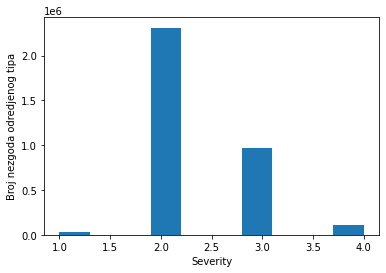

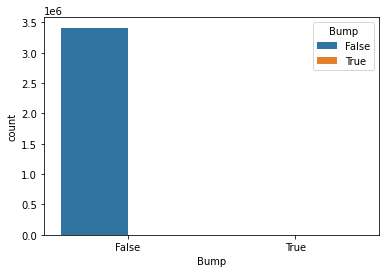

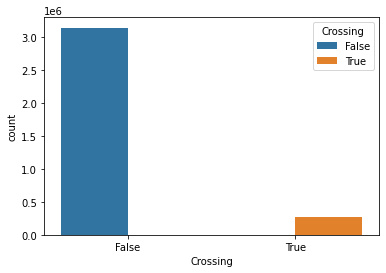

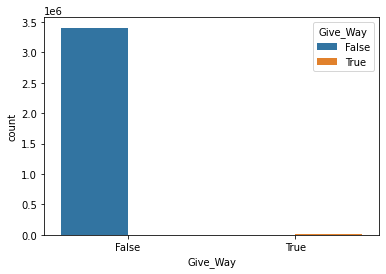

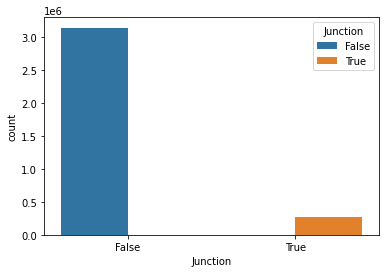

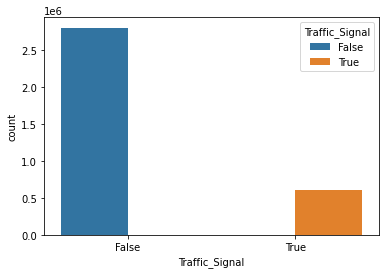

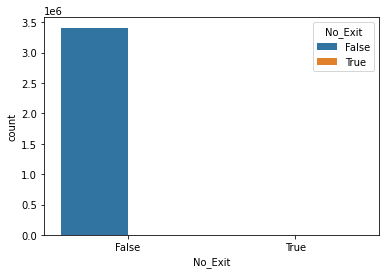

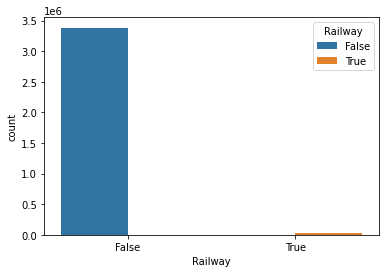

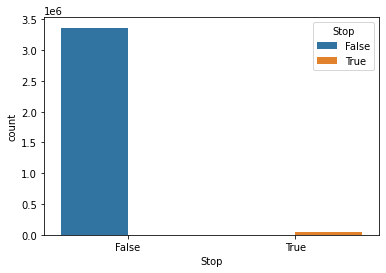

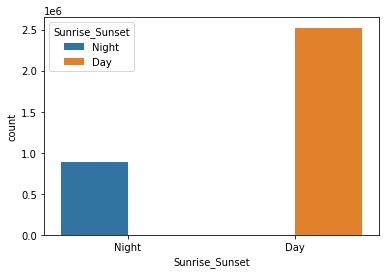

In [ ]:
import seaborn as sns
podaci.Severity.plot(kind='hist')
plt.xlabel('Severity')
plt.ylabel('Broj nezgoda odredjenog tipa')
plt.show()

plt.figure()
sns.countplot(x='Bump', hue='Bump',data=podaci)
plt.figure()
sns.countplot(x='Crossing', hue='Crossing',data=podaci)
plt.figure()
sns.countplot(x='Give_Way', hue='Give_Way',data=podaci)
plt.figure()
sns.countplot(x='Junction', hue='Junction',data=podaci)
plt.figure()
sns.countplot(x='Traffic_Signal', hue='Traffic_Signal',data=podaci)
plt.figure()
sns.countplot(x='No_Exit', hue='No_Exit',data=podaci)
plt.figure()
sns.countplot(x='Railway', hue='Railway',data=podaci)
plt.figure()
sns.countplot(x='Stop', hue='Stop',data=podaci)
plt.figure()
sns.countplot(x='Sunrise_Sunset', hue='Sunrise_Sunset',data=podaci)

Radi uvida u informativnost podataka mozemo uraditi korelaciju izmedju obelezja koji predstavljaju brojeve i videti njihovu povezanost. Sto je koeficijent korelacije veci izmedju tih obelezja, ona su slicnija, odnosno nose slicnu kolicinu informacija. Sa datog grafika se moze videti da je maksimalni koeficijent korelacije po apsolutnoj vrednosti 0.43 sto je prihvatljivi koeficijent korelacije kada su ova obelezja u pitanju.

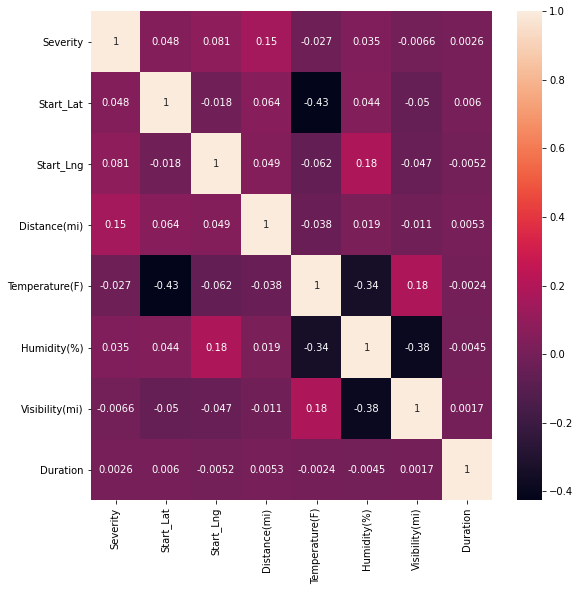

In [ ]:
plt.figure(figsize = (9,9))
sns.heatmap(podaci[['Severity','Start_Lat','Start_Lng','Distance(mi)','Temperature(F)','Humidity(%)','Visibility(mi)','Duration']].corr(), annot = True)
plt.show()

Sada je potrebno konvertovati obelezja tipa object u obelezja koja se mogu koristiti u modelu. TO se moze obaviti uz pomoc funkcije **get_dummies()** u okviru pandas biblioteke. Ovim putem se datim obelezjima dodeljuju vrednosti 0 ili 1 u zavisnosti od kolicine podataka koja se posmatra. Kada je u pitanju informacija o drzavi, kao prag za odredjivanje labele koju treba dodeliti koristi se broj saobracajnih nezgoda koji se dogodio u tim drzavama.

In [ ]:
State=podaci[['State']]
State=pd.get_dummies(State,drop_first=True)

Side=podaci[['Side']]
Side=pd.get_dummies(Side,drop_first=True)

Sunrise_Sunset=podaci[['Sunrise_Sunset']]
Sunrise_Sunset=pd.get_dummies(Sunrise_Sunset,drop_first=True)

Weather_Condition=podaci[['Weather_Condition']]
top46=[x for x in podaci.Weather_Condition.value_counts().sort_values(ascending=False).head(8).index]
for label in top46:
    Weather_Condition[label]=np.where(podaci['Weather_Condition']==label,1,0)
Weather_Condition.drop(['Weather_Condition'],axis=1,inplace=True)

City=podaci[['City']]
top46=[x for x in podaci.City.value_counts().sort_values(ascending=False).head(46).index]
for label in top46:
    City[label]=np.where(podaci['City']==label,1,0)
City.drop(['City'],axis=1,inplace=True)

podaci.drop(['ID','Start_Lat','Start_Lng','Street','Side','City','County','State','Weather_Condition','Sunrise_Sunset'],axis=1,inplace=True)
podaci1=pd.concat([podaci,Weather_Condition,Side,Sunrise_Sunset],axis=1)
podaci2=podaci1.head(500000) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

Kada je pretprocesiranje zavrseno, mozemo koristiti dobijena obelezja za treniranje zeljenih modela. Dobijamo matricu X koja predstavlja obelezja i matricu y koja predstavlja labele, odnosno zeljene izlaze. Nakon toga vrsimo podelu na trening i test skup podataka koji ce se koristiti za treniranje modela i njihovu predikciju.

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix  
from sklearn import svm
from sklearn.metrics import classification_report
import itertools

X=podaci2.drop(['Severity'],axis=1)
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
y=podaci2['Severity']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

Prvi algoritam koji ce se koristiti nije u sklopu predmeta obradjen, ali se nalazi u sklopu izabranog projekta, pa ce biti ubacen u razmatranje, a to je KNN klasifikator koji se bazira na principu k najblizih suseda. Za velicinu K uzete su vrednosti od 1 do 10, gde se za najbolju vrednost pokazala vrednost 7, a ponekad i vrednost 9. Kada je u pitanju tacnost modela, ona se krece oko vrenodsti 67.2% dok se F1 score krece oko vrednosti 67.07%.

In [ ]:
l={}
for k in range(1,10):
    nknn=KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
    ypred=nknn.predict(X_test)
    accuracy=accuracy_score(y_test,ypred)
    l[k]=accuracy

best_k = max(l, key=l.get)
nknn=KNeighborsClassifier(n_neighbors=best_k).fit(X_train,y_train)
ypred=nknn.predict(X_test)
print('Vrednost najboljeg parametra K:'+str(best_k))
print('Accuracy:'+str(accuracy_score(y_test,ypred)))
print('F1 score:'+str(f1_score(y_test,ypred,average='weighted')))

{1: 0.65419, 2: 0.65873, 3: 0.6668, 4: 0.6654, 5: 0.67106, 6: 0.6685, 7: 0.67207, 8: 0.66839, 9: 0.67247}
Best K for KNN model :7
Corresponding Accuracy: 0.67207
f1 score: 0.6707840478582769


Drugi algoritam koji se posmatra je algoritam baziran na stablima odlucivanja. Eksperimentalnim putem, proverom raznih kombinacija parametara, dosao sam do zakljucka da su najbolji rezultati dobijeni za dubinu 4. Tacnost se krece oko vrednosti 67.54% dok se F1 score krece oko vrednosti 67.52%.

In [ ]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
tree=tree.fit(X_train,y_train)
tree.score(X_test,y_test)
ypred=tree.predict(X_test)
print('Accuracy:'+str(accuracy_score(y_test,ypred)))
print('F1 score:'+str(f1_score(y_test,ypred,average='weighted')))

Accuracy:0.6754
F1 score:0.67519080668298


Treci algoritam koji se posmatra je logisticka regresija. Takodje, eksperimentalnim putem dobijen je parametar C koji predstavlja konstantu regularizacije i on iznosi u ovom slucaju 0.01. Tacnost ovog algoritma krece se oko vrednosti 67.08% dok je F1 score oko 67.21%.

In [ ]:
model= LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
model.score(X_test,y_test)
ypred=model.predict(X_test)
print('Accuracy:'+str(accuracy_score(y_test,ypred)))
print('F1 score:'+str(f1_score(y_test,ypred,average='weighted')))

Accuracy:0.67088
F1 score:0.6720916706047082


Cetvrti i poslednji algoritam je algoritam Support Vector Machines. Kada je on u pitanju, korisceni kernel je gausovski kernel koji je davao najbolje rezultate. Tacnost se krece u opsegu 67.74%, dok je vrednost F1 score oko 67.32%.

In [ ]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_test, y_test)
clf.score(X_test, y_test)
ypred=clf.predict(X_test)
print('F1 score:' +str(f1_score(y_test,ypred,average='weighted')))
print('Accuracy:'+str(accuracy_score(y_test,ypred)))

F1 score:0.6774341492949696
Accuracy:0.67319
